In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader

### Load datasets

In [2]:
set_global_seed(42)
# data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
# data_path = Path("../data/sat1/split_stage_data_unprocessed_500hz.nc")

dataset = xr.load_dataset(data_path)

In [3]:
channels = list(dataset.channels.to_numpy())
channels_upper = [ch.upper() for ch in channels]
dataset["channels"] = channels_upper
dataset = dataset.reindex({"channels": AR_SAT1_CHANNELS})

In [3]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological)

#### Transformer (single run)

In [ ]:
# TODO: Look into tensor device mismatch
model = TransformerModel(len(train_data.channels), 6, 512, 6, len(train_data.samples))

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=0,
    batch_size=128,
)

#### LSTM (Single run)

In [5]:
model = SAT1GRU(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

  0%|          | 0/96 [00:00<?, ? batch/s]

{'0': {'precision': 0.7241715399610137,
  'recall': 0.8376550169109357,
  'f1-score': 0.7767903815995818,
  'support': 887.0},
 '1': {'precision': 0.8907168037602821,
  'recall': 0.851685393258427,
  'f1-score': 0.8707639287765652,
  'support': 890.0},
 '2': {'precision': 0.9490683229813665,
  'recall': 0.8584269662921349,
  'f1-score': 0.9014749262536873,
  'support': 890.0},
 '3': {'precision': 0.9553349875930521,
  'recall': 0.8406113537117904,
  'f1-score': 0.894308943089431,
  'support': 458.0},
 '4': {'precision': 0.867741935483871,
  'recall': 0.9067415730337078,
  'f1-score': 0.8868131868131869,
  'support': 890.0},
 'accuracy': 0.8610211706102117,
 'macro avg': {'precision': 0.8774067179559172,
  'recall': 0.8590240606413992,
  'f1-score': 0.8660302733064904,
  'support': 4015.0},
 'weighted avg': {'precision': 0.8691364048925901,
  'recall': 0.8610211706102117,
  'f1-score': 0.8630542669126898,
  'support': 4015.0}}

#### GRU (Single run, with manual test/train selection)

In [ ]:
model = SAT1GRU(len(dataset.channels), len(dataset.samples), len(dataset.labels))
test_dataset = SAT1Dataset(dataset.sel(participant=["0014"]))
train_dataset = SAT1Dataset(
    dataset.sel(participant=[p for p in dataset.participant.values if p != "0014"])
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    test_dataset,
    logs_path=Path("../logs/"),
    workers=0,
    batch_size=128,
)

#### CNN (Deep, for 500Hz data, single run)

In [ ]:
model = SAT1Deep(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
)

#### CNN (Deep, for topological 500Hz data, single run)

In [ ]:
height, width = CHANNELS_2D.shape
model = SAT1TopologicalConv(
    width, height, len(train_data.samples), len(train_data.labels)
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
)

#### CNN K-Fold CV (Deep)

In [ ]:
train_kwargs = {"logs_path": Path("../logs/")}
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
results = k_fold_cross_validate(
    SAT1Deep,
    model_kwargs,
    dataset,
    k=25,
    batch_size=128,
    normalization_fn=norm_dummy,
    train_kwargs={
        "logs_path": Path("../logs/CNN_performance"),
        "additional_name": "CNN_DEEP",
    },
)
print_results(results)

#### GRU K-Fold CV

In [ ]:
train_kwargs = {"logs_path": Path("../logs/")}
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
results = k_fold_cross_validate(
    SAT1GRU,
    model_kwargs,
    dataset,
    k=25,
    batch_size=128,
    normalization_fn=norm_min1_to_1,
    train_kwargs={
        "logs_path": Path("../logs/GRU_performance"),
        "additional_name": "GRU",
    },
)
print_results(results)

### Examine results using confusion matrix

In [4]:
chk_path = Path("../models/cnn100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
model = SAT1Base(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

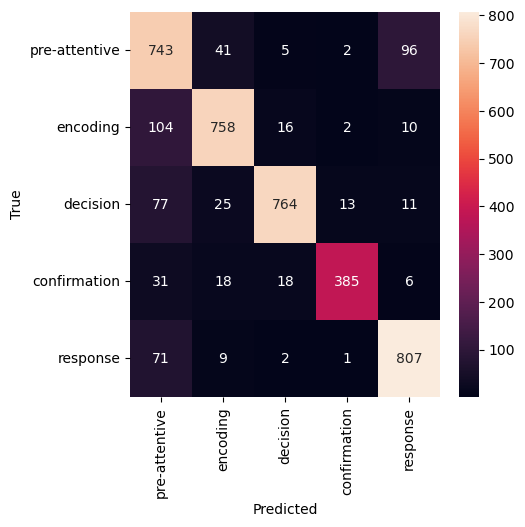

In [7]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)